<a href="https://colab.research.google.com/github/giuliamf/tag_projeto2/blob/main/tag_projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Função auxiliar para visualizar o grafo durante o desenvolvimento

In [2]:
from visualizar_grafo import visualizar_grafo_bipartido

Trata os dados do arquivo dados.txt

In [3]:
import pandas as pd
import re

In [4]:
with open('dados.txt', 'r', encoding='utf-8') as file:
  linhas = file.readlines()

linhas = [linha.strip() for linha in linhas if linha.strip()]

split_id = next(i for i, l in enumerate(linhas) if l.startswith('//alunos'))

projeto_linhas = linhas[2:split_id]
estudante_linhas = linhas[split_id+2:]

Trata os dados dos projetos em um dataframe

In [5]:
projetos = []
for linha in projeto_linhas:
  match = re.match(r'\((P\d+),\s*(\d+),\s*(\d+)\)', linha)
  if match:
    codigo, vagas, nota_min = match.groups()
    projetos.append({'projeto': codigo, 'vagas': int(vagas), 'nota_min': int(nota_min)})

df_projetos = pd.DataFrame(projetos)

In [6]:
df_projetos.head()

,projeto,vagas,nota_min
0,P1,2,5
1,P2,1,5
2,P3,2,4
3,P4,1,5
4,P5,2,4


Trata os dados dos estudantes em um dataframe

In [7]:
alunos = []
for linha in estudante_linhas:
  match = re.match(r'\((A\d+)\):\((P\d+(?:,\s*P\d+){0,2})\)\s*\((\d+)\)', linha)
  if match:
    codigo, preferencias, nota = match.groups()
    prefs = [p.strip() for p in preferencias.split(',')]
    alunos.append({
        'aluno': codigo,
        'pref_1': prefs[0] if len(prefs) > 0 else None,
        'pref_2': prefs[1] if len(prefs) > 1 else None,
        'pref_3': prefs[2] if len(prefs) > 2 else None,
        'nota': int(nota)
        })

df_alunos = pd.DataFrame(alunos)

In [8]:
df_alunos.head()

,aluno,pref_1,pref_2,pref_3,nota
0,A1,P1,P30,P50,5
1,A2,P1,P30,P51,5
2,A3,P30,P34,P35,3
3,A4,P2,P3,P5,4
4,A5,P4,P28,P34,3


Começando a criar um grafo bipartido com os dados tratados acima

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

cria o grafo

In [10]:
grafo = nx.Graph()

- adiciona os alunos - bipartido 1
- faz o dicionario de requisitos para o projeto


In [11]:
grafo.add_nodes_from(df_alunos['aluno'], bipartite=0)

requisitos = df_projetos.set_index('projeto').to_dict('index')

- adiciona as vagas do projeto - bipartido 2

In [12]:
for _, row in df_projetos.iterrows():
  for i in range(row['vagas']):
    vaga = f'{row["projeto"]}-{i+1}'
    grafo.add_node(vaga, bipartite=1)

- cria as arestas: aluno -> vaga do projeto se a nota for maior ou igual o requisito

In [13]:
for _, aluno in df_alunos.iterrows():
  aluno_id = aluno['aluno']
  nota = aluno['nota']
  for pref in ['pref_1', 'pref_2', 'pref_3']:
    projeto = aluno[pref]
    if projeto in requisitos and nota >= requisitos[projeto]['nota_min']:
      for i in range(requisitos[projeto]['vagas']):
        vaga = f'{projeto}-{i+1}'
        grafo.add_edge(aluno_id, vaga)

informações do grafo até aqui

In [14]:
n_alunos = len([n for n, d in grafo.nodes(data=True) if d.get("bipartite") == 0])
n_vagas = len([n for n, d in grafo.nodes(data=True) if d.get("bipartite") == 1])
n_arestas = grafo.number_of_edges()

df_stats = pd.DataFrame({
    "Tipo": ["Alunos", "Vagas", "Arestas"],
    "Quantidade": [n_alunos, n_vagas, n_arestas]
})

df_stats

,Tipo,Quantidade
0,Alunos,200
1,Vagas,80
2,Arestas,433


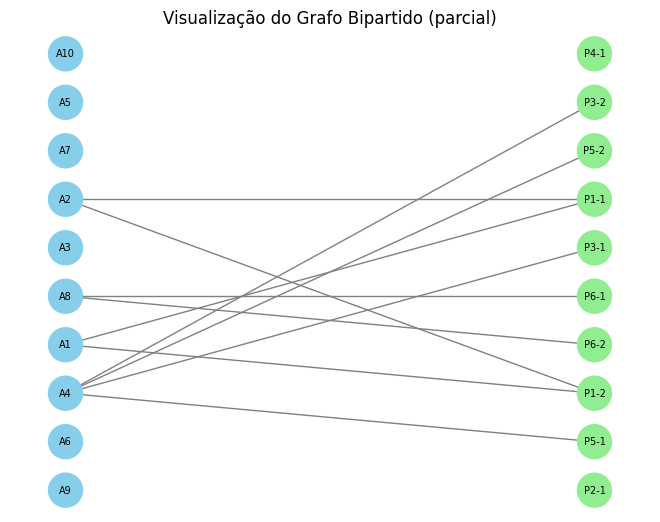

In [15]:
visualizar_grafo_bipartido(grafo, max_nos=20)

Emparelhamento estável

In [18]:
pref_alunos = []

for _, aluno in df_alunos.iterrows():
  aluno_id = aluno['aluno']
  aluno_nota = aluno['nota']

  for pref in ['pref_1', 'pref_2', 'pref_3']:
    projeto = aluno[pref]
    if projeto in requisitos:
      req = requisitos[projeto]
      if aluno_nota >= req['nota_min']:
        for i in range(req['vagas']):
          pref_alunos.append({
              'aluno': aluno_id,
              'projeto': projeto,
              'vaga': f'{projeto}-{i+1}',
              'ordem': int(pref[-1])
          })

df_pref_alunos = pd.DataFrame(pref_alunos)

In [19]:
df_pref_alunos.head()

,aluno,projeto,vaga,ordem
0,A1,P1,P1-1,1
1,A1,P1,P1-2,1
2,A1,P30,P30-1,2
3,A1,P50,P50-1,3
4,A1,P50,P50-2,3
